In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from scipy.fft import fft, fftfreq
import itertools
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [267]:
df = pd.read_csv('data.csv')
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
def plot_ts(df : pd.DataFrame, var : str, diff : bool =False):
    if diff:
        var = var+'_diff'
    plt.figure(figsize=(20, 6))
    plt.plot(df['Date'], df[var])
    plt.title(f'{var}')
    plt.xticks(ticks=df['Date'][df['Date'].dt.is_month_start],
            labels=df['Date'][df['Date'].dt.is_month_start].dt.strftime('%m/%y'))
    plt.grid(True)

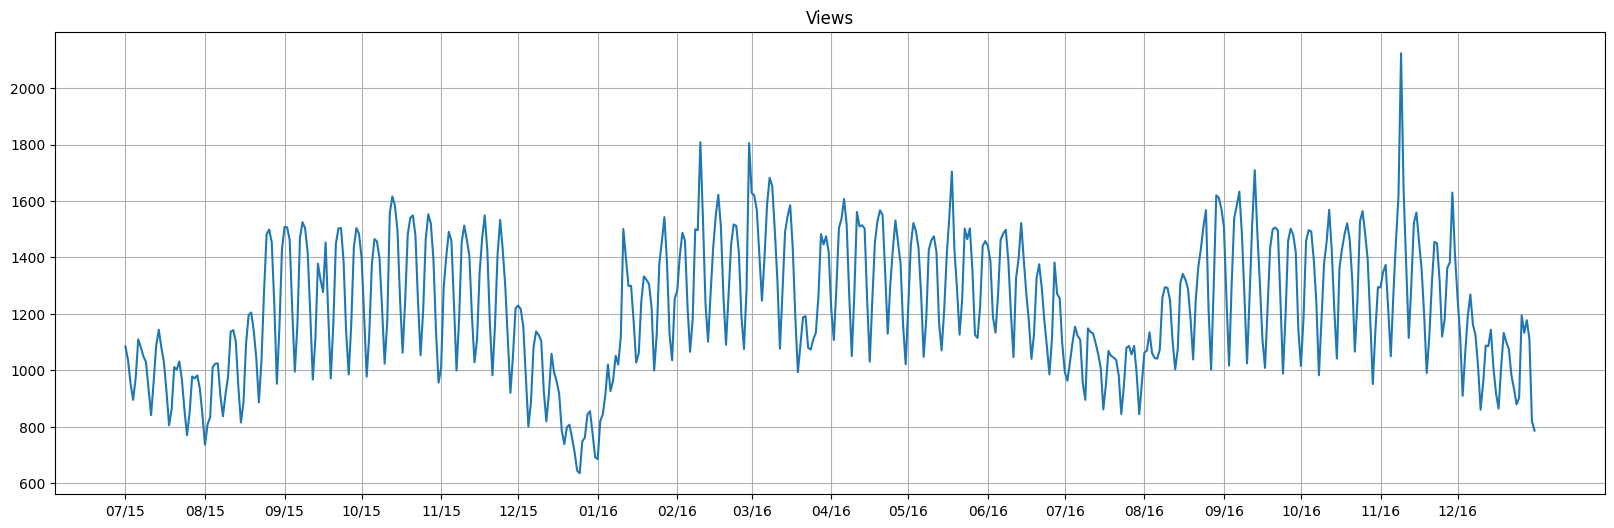

In [269]:
plot_ts(df, 'Views')

In [270]:
def test_stationarity(df : pd.DataFrame, var : str, conf : float=0.05, verbose : bool=False):
    temp = df
    test = adfuller(temp[var])
    test_stat = round(test[0],3)
    pval = round(test[1],3)
    if pval < conf:
        if verbose == True:
            print(f'Time series is stationary with p-value {pval} < {conf} and test statistic {test_stat}')
        return 0, temp
    else:
        if verbose == True:
            print(f'Time series is not stationary with p-value {pval} < {conf} and test statistic {test_stat}')
            print('Differencing...')
        diff = temp[var].diff().dropna()
        test = adfuller(diff)
        test_stat = round(test[0],3)
        pval = round(test[1],3)
        if pval < conf:
            if verbose == True:
                print(f'Time series is stationary with p-value {pval} < {conf} and test statistic {test_stat}')
            temp_diff = temp[var].diff().dropna().to_frame(name=var+'_diff')
            temp = temp.join(temp_diff, how='left')
            return 1, temp
        else:
            print('Time series is not stationary after differencing')      
            return

In [271]:
def plot_spec(df : pd.DataFrame, var : str):
    data = df[var].values
    n = len(data)
    fft_vals = np.abs(fft(data))
    freq = fftfreq(n, d=1)
    pos_freq = freq[:n // 2]
    pos_magnitude = fft_vals[:n // 2]
    with np.errstate(divide='ignore'):
        periods = 1 / pos_freq
    
    l = [[pos_magnitude[i], periods[i]] for i in range(len(pos_magnitude))]
    l.sort(key=lambda x: x[0], reverse=True)
    print(f'Dominant frequencies, which correspond to seasonal cycles: {[int(l[i][1]) for i in range(1,4)]}')
    plt.figure(figsize=(20, 5))
    plt.plot(periods, pos_magnitude)
    plt.xlim([1, 15])
    plt.xticks(np.arange(1, 15, 1))
    plt.title("Spectral Plot for Seasonality Detection")
    plt.xlabel("Frequency")
    plt.ylabel("Magnitude")
    plt.grid(True)

In [272]:
def plot_cf(df : pd.DataFrame, var : str, type : str, lags : int = 30, diff : bool=False):
    df = df.dropna().reset_index(drop=True)
    if diff:
        var = var+'_diff'
    if type == 'pacf':
        fig = tsaplots.plot_pacf(df[var], lags=lags)
        plt.title(f'PACF of {var}')
        fig.figure.set_size_inches(20, 6)
        cf_vals, civals = sm.tsa.pacf(df[var], nlags=lags, alpha=0.01)
        civals = civals - cf_vals.reshape(-1,1)
        plt.fill_between(x=range(lags+1), y1=civals[:,0], y2=civals[:,1], color='gray', alpha=0.1)
    
    if type == 'acf':
        fig = tsaplots.plot_acf(df[var], lags=lags)
        plt.title(f'ACF of {var}')
        fig.figure.set_size_inches(20, 6)
        cf_vals, civals = sm.tsa.acf(df[var], nlags=lags, alpha=0.01)
        civals = civals - cf_vals.reshape(-1,1)
        plt.fill_between(x=range(lags+1), y1=civals[:,0], y2=civals[:,1], color='gray', alpha=0.1)

In [354]:
def plot_subseries(df : pd.DataFrame, var : str, diff : bool=False): 
    if diff:
        var = var+'_diff'
    df["Weekday"] = df["Date"].dt.day_name()
    df["Week"] = df["Date"].dt.isocalendar().week
    weeks = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    df["Weekday"] = pd.Categorical(df["Weekday"], categories=weeks, ordered=True)
    df = df.sort_values(by=["Weekday", "Date"])
    count = 0
    colors = plt.colormaps["Blues"](np.linspace(0.8, 0.8, len(weeks)))
    plt.figure(figsize=(20, 6))
    plt.title(f'Subseries plot of {var} by weekdays')
    plt.grid(True)
    for i,day in enumerate(weeks):
        temp = df[df["Weekday"] == day]
        n = len(temp)
        xvals = range(count, count + n)
        plt.plot(xvals, temp[var], lw = 1.2, color=colors[i])
        plt.plot(xvals, temp[var].mean() * np.ones(n), linestyle="--", color="black", lw = 1)
        count = count + 100
        plt.xticks([50,150,250,350,450,550,650], weeks)
    

In [ ]:
def main(df : pd.DataFrame, var : str, conf : float=0.05, lags : int=30):
    diff, temp = test_stationarity(df, var, conf, verbose=True)
    if diff:
        plot_ts(df, var)
        plot_ts(temp, var, diff=diff)
        plot_spec(temp, var)
        plot_subseries(temp, var, diff=diff)
        plot_cf(temp, var, 'acf', lags=lags, diff=diff)
        plot_cf(temp, var, 'pacf', lags=lags, diff=diff)
    else:
        plot_ts(df, var)
        plot_spec(temp, var)
        plot_subseries(df, var)
        plot_cf(temp, var, 'acf', lags=lags, diff=diff)
        plot_cf(temp, var, 'pacf', lags=lags, diff=diff)

Time series is not stationary with p-value 0.034 < 0.01 and test statistic -3.014
Differencing...
Time series is stationary with p-value 0.0 < 0.01 and test statistic -6.019
Dominant frequencies, which correspond to seasonal cycles: [183, 6, 7]


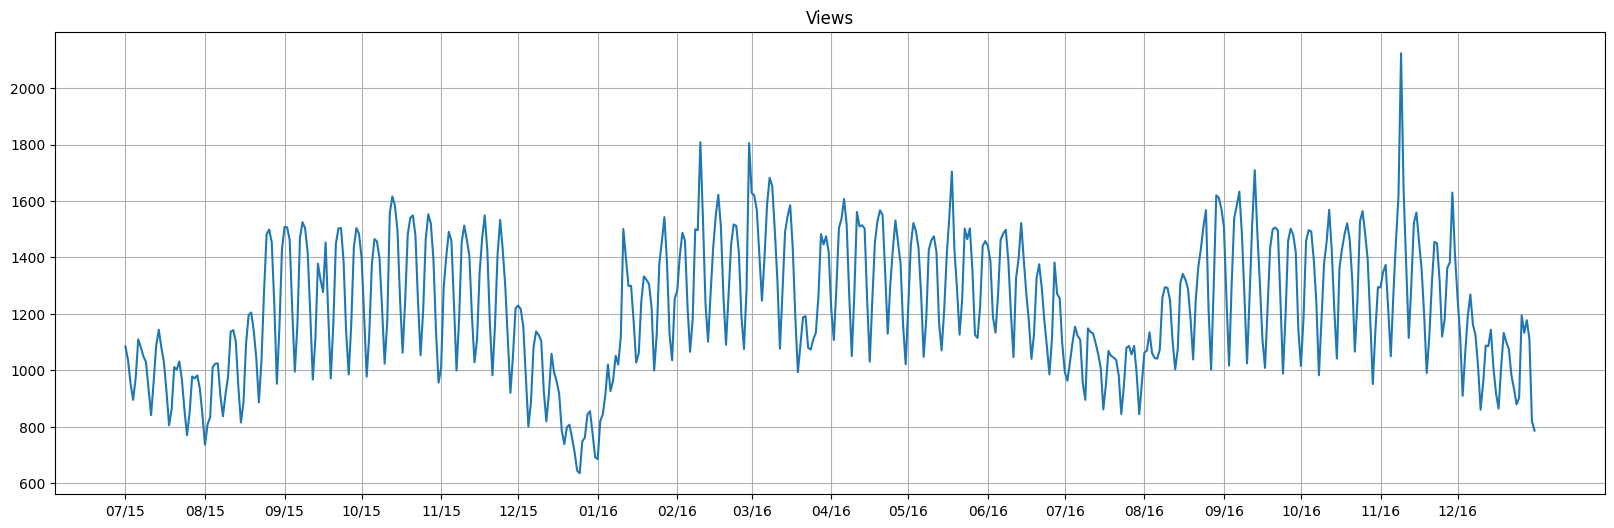

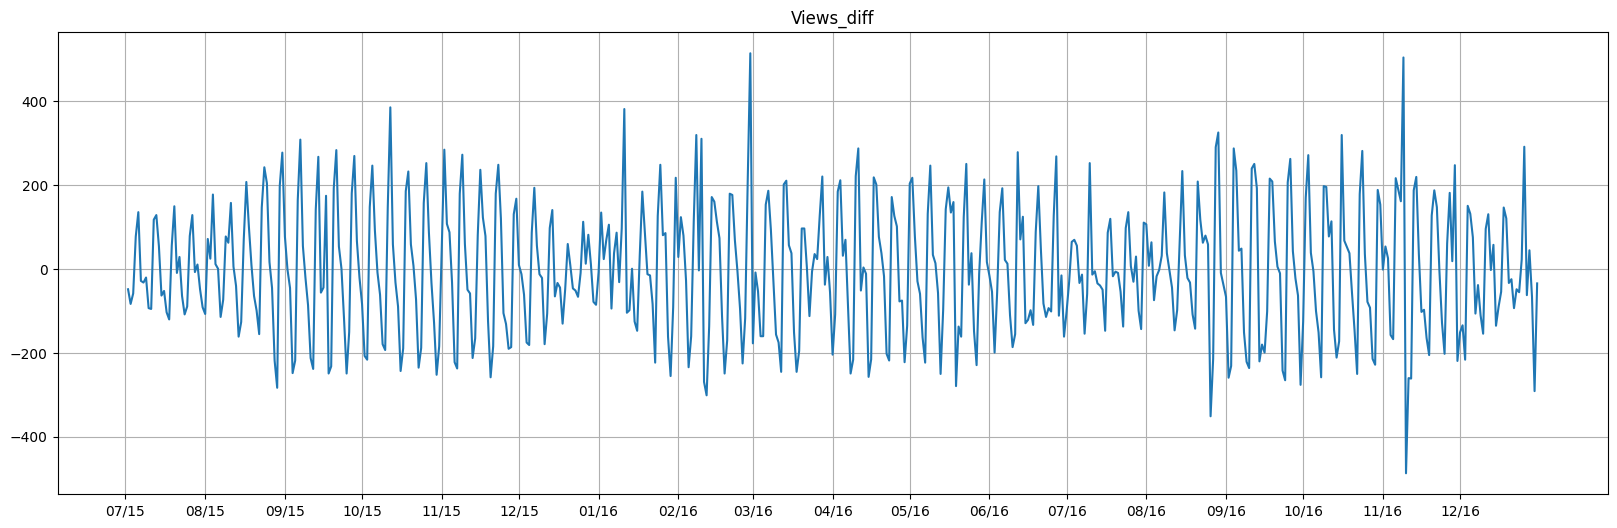

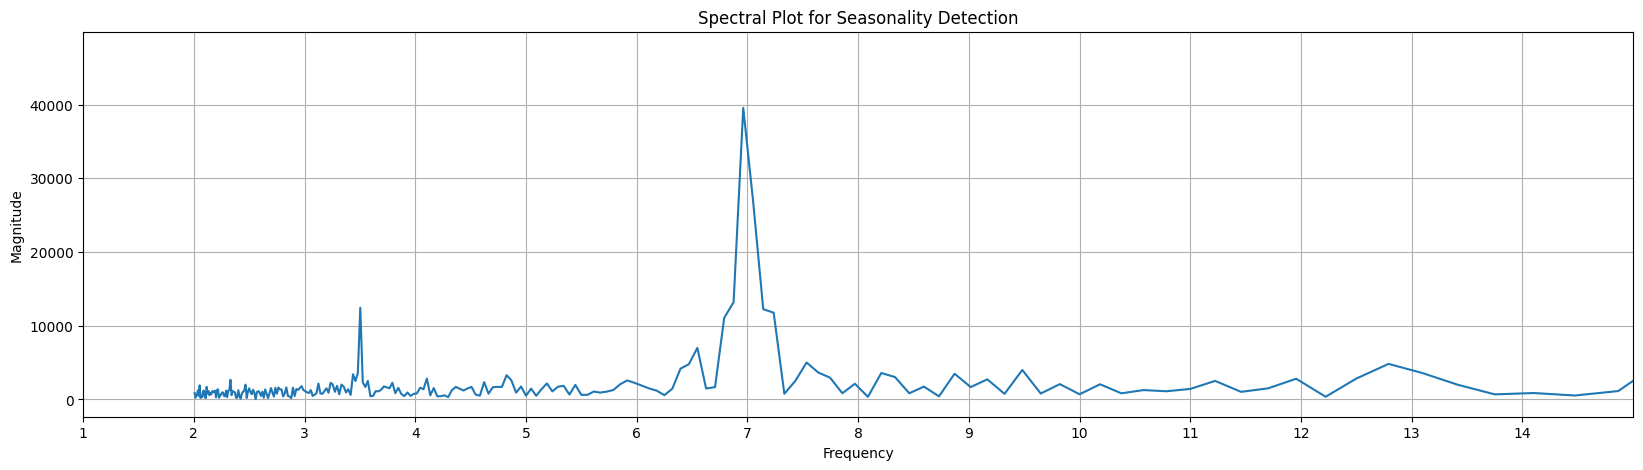

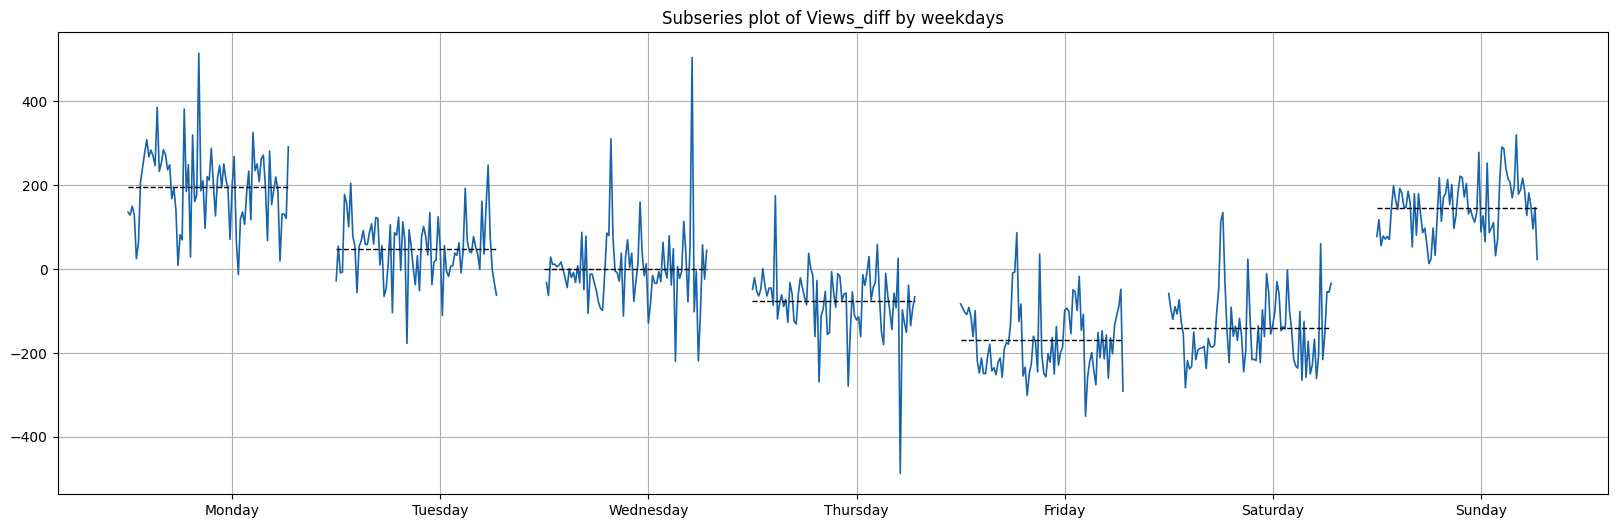

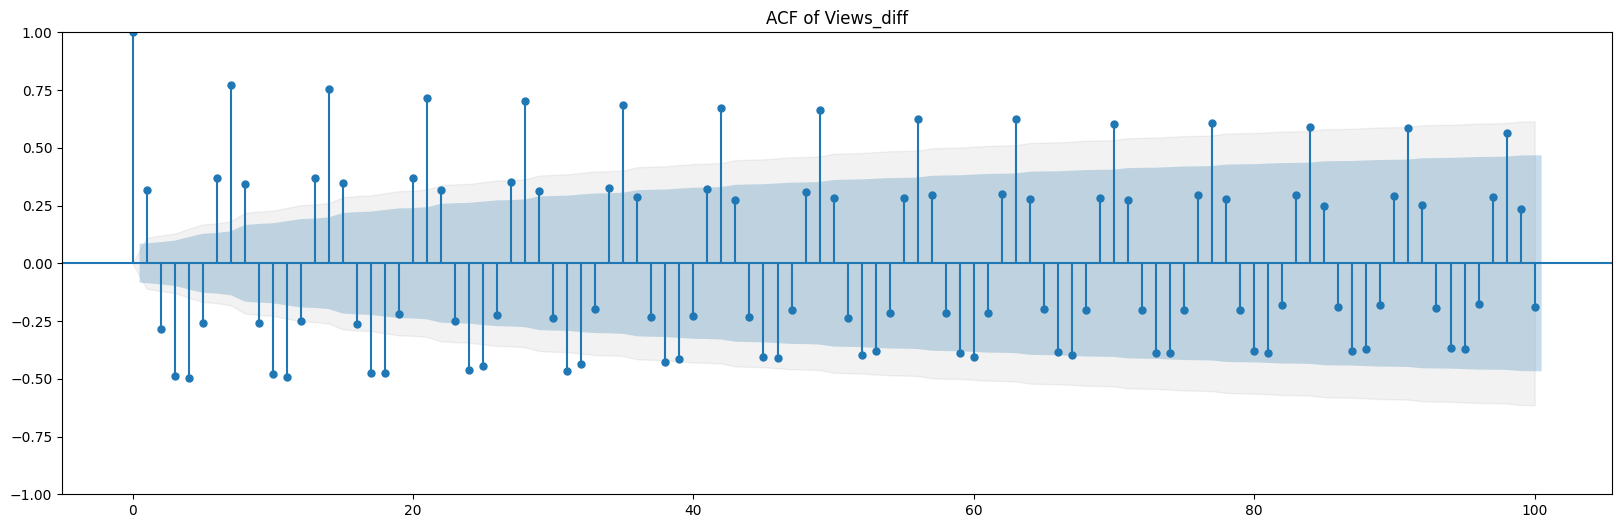

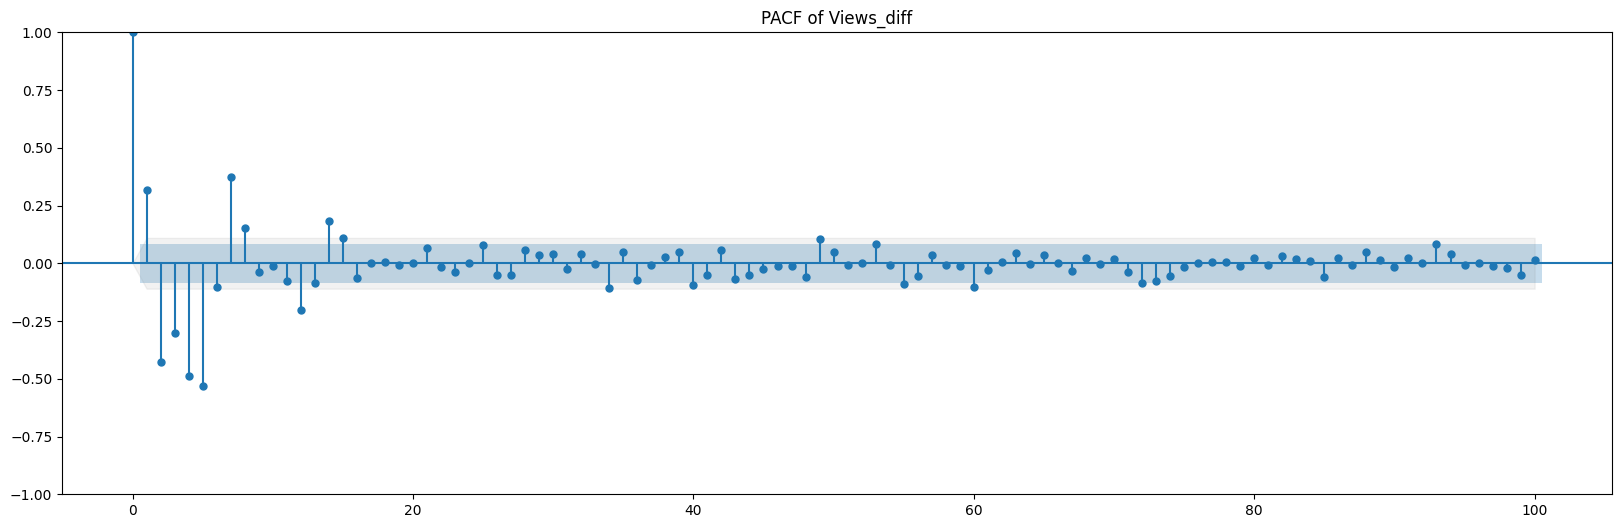

In [356]:
main(df, 'Views', conf=0.01, lags=100)

The autocorrelation plot shows an alternating pattern of positive and negative spikes. It also shows a repeating pattern every 7 lags, which indicates a seasonality effect.

A significant seasonal pattern is obvious in the subseries plot, so we need to include seasonal terms

In [ ]:
date_range = pd.date_range(start='2022-01-01', end='2024-12-31', freq='M')
data = np.sin(2 * np.pi * date_range.month / 12) + np.random.normal(scale=0.5, size=len(date_range))
time_series = pd.Series(data, index=date_range)

# Step 1: Prepare the data by extracting seasonal components
time_series_df = time_series.to_frame(name='values')
time_series_df['Month'] = time_series_df.index.month

# Step 2: Plot the Seasonal Subseries Plot
plt.figure(figsize=(12, 8))
for month in range(1, 13):
    plt.subplot(3, 4, month)
    plt.plot(time_series_df[time_series_df['Month'] == month].index, 
             time_series_df[time_series_df['Month'] == month]['values'], marker='o')
    plt.title(f"Month {month}")
    plt.xlabel("Year")
    plt.ylabel("Values")
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.suptitle("Seasonal Subseries Plot", y=1.02, fontsize=16)
plt.show()


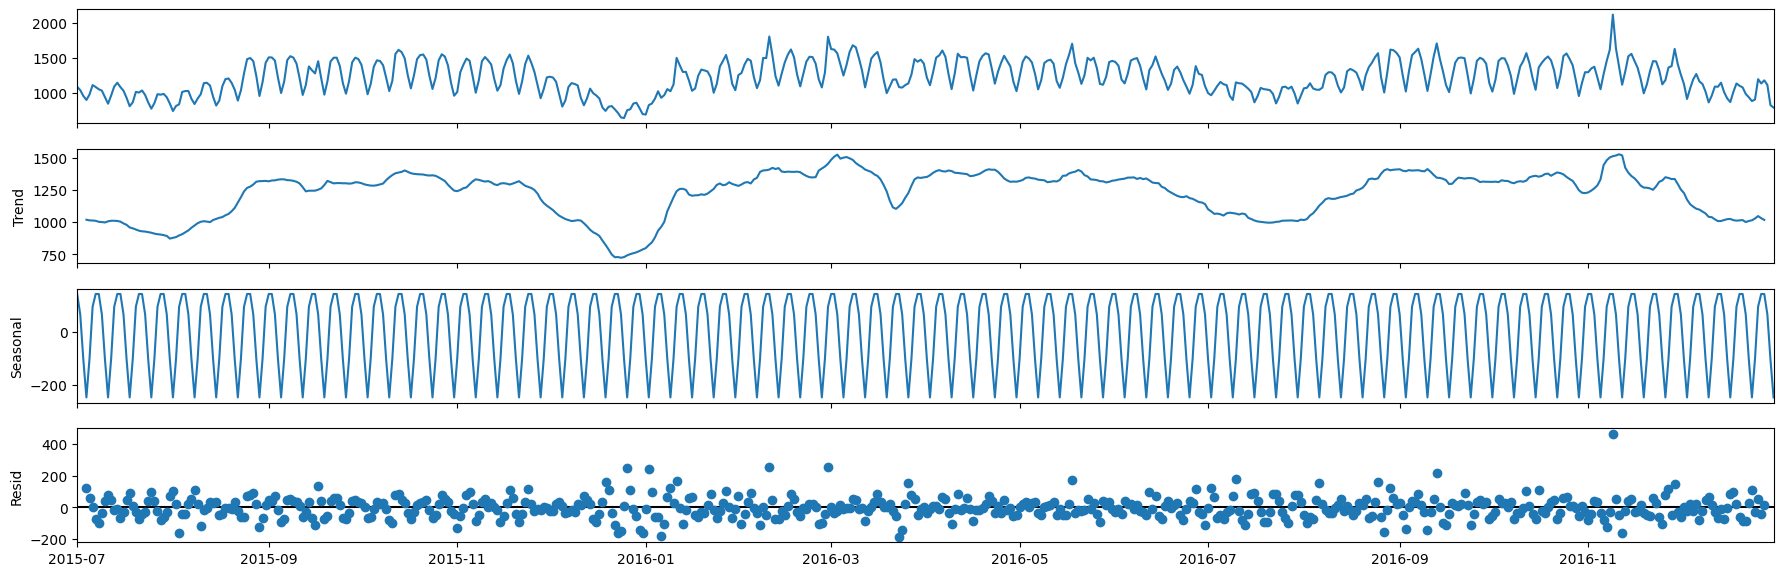

In [91]:
t = df.set_index('Date')
sd = seasonal_decompose(t, model='additive').plot()
sd.figure.set_size_inches(20, 6)

In [ ]:
train = df[:-12]
validation = df[-12:]

# Find the best p, d, q combination for the lowest AIC
p = d = q = range(0, 3)  # ranges for ARIMA parameters, 0 - 2

best_aic = float("inf")
best_params = None

for param in itertools.product(p, d, q):
    try:
        # ARIMA model does not use seasonal_order, so we exclude it
        model = ARIMA(train['Views'], order=param)
        results = model.fit()  

        # Check if the current model AIC is lower than what we've seen before
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = param

    except Exception as e:
        print(f"ARIMA{param} - AIC: None - Exception: {e}")
        continue  # Continue to the next iteration

# Print out the best parameters and AIC
if best_params is not None:
    print(f"Best ARIMA parameters: {best_params}")
    print(f"Best AIC: {best_aic}")
else:
    print("No suitable ARIMA model was found.")

Best ARIMA parameters: (2, 1, 2)
Best AIC: 6428.434442368988


In [93]:
# Fit the model with the best parameters

best_model = ARIMA(train['Views'],
                     order=best_params)
best_model_fit = best_model.fit()

# Summarize the final model
print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Views   No. Observations:                  538
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3209.217
Date:                Fri, 08 Nov 2024   AIC                           6428.434
Time:                        20:05:21   BIC                           6449.864
Sample:                             0   HQIC                          6436.818
                                - 538                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2365      0.009    132.335      0.000       1.218       1.255
ar.L2         -0.9770      0.009   -110.773      0.000      -0.994      -0.960
ma.L1         -1.3196      0.023    -57.749      0.0

In [94]:
# Generate forecasts for the validation period
forecast_result = best_model_fit.get_forecast(steps=12)

# Get the forecast values
forecasted_values = forecast_result.predicted_mean

# Get the confidence intervals of the forecasts
conf_int = forecast_result.conf_int(alpha=0.05)
# print(conf_int)

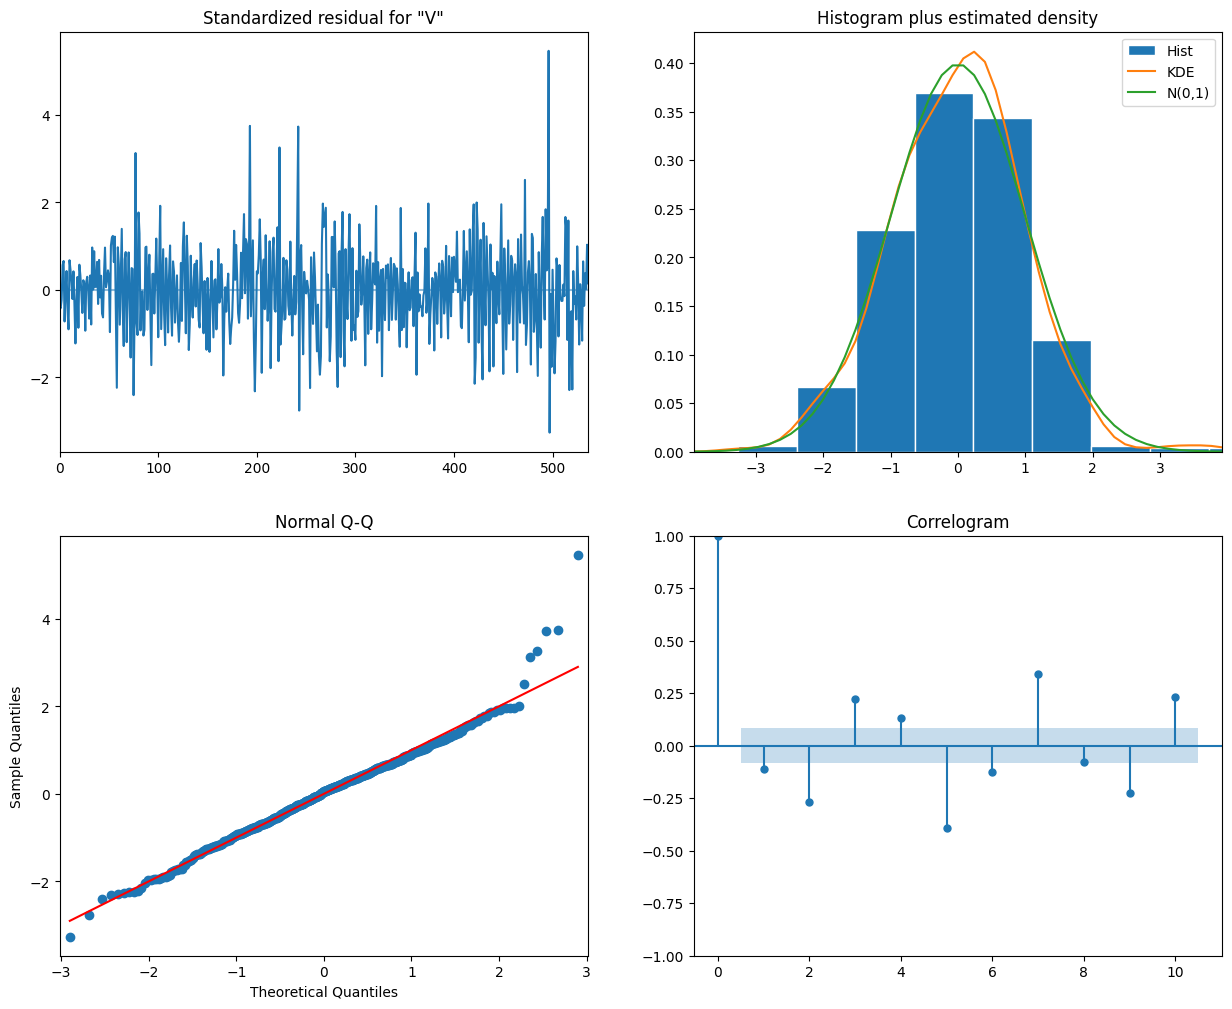

In [95]:
best_model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

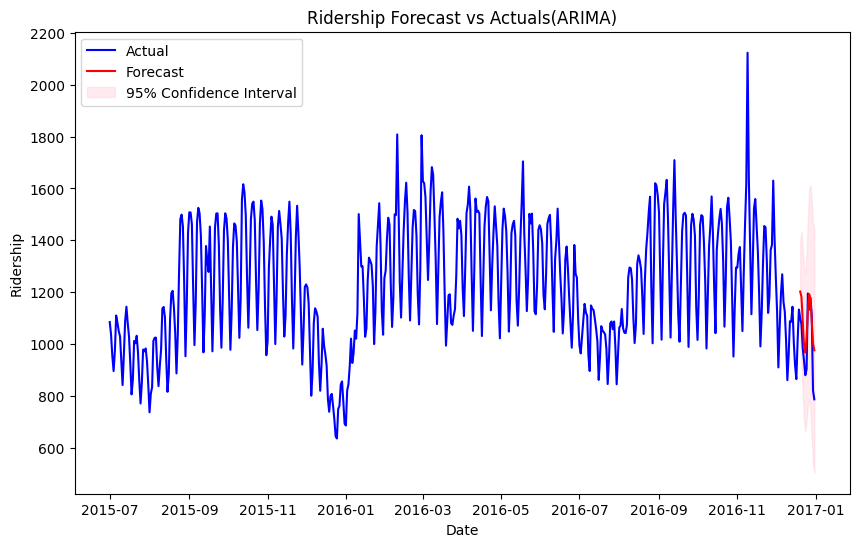

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(df['Date'], df['Views'], label='Actual', color='blue')

# Plot the forecasted values
plt.plot(validation['Date'], forecasted_values, label='Forecast', color='red')

# Plot the confidence interval as a shaded area around the line
plt.fill_between(validation['Date'],
                 conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='pink', alpha=0.3, label='95% Confidence Interval')

plt.title('Ridership Forecast vs Actuals(ARIMA)')
plt.xlabel('Date')
plt.ylabel('Ridership')
plt.legend()
plt.show()

In [97]:
train = df[:-12]
validation = df[-12:]
params = [2, 1, 2]
seasonal_param = [2, 1, 2, 7]
best_aic = float("inf")

model = SARIMAX(train['Views'],
                order=param,
                seasonal_order=seasonal_param,
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit(disp=0)  # Set disp=0 to reduce output verbosity

if results.aic < best_aic:
    best_aic = results.aic
    best_params = param
    best_seasonal_params = seasonal_param

# Print out the best parameters and AIC
if best_params is not None:
    print(f"Best SARIMA parameters: {best_params}")
    print(f"Best Seasonal parameters: {best_seasonal_params}")
    print(f"Best AIC: {best_aic}")
else:
    print("No suitable model was found.")

Best SARIMA parameters: (2, 2, 2)
Best Seasonal parameters: [2, 1, 2, 7]
Best AIC: 6019.883774485843


In [98]:
best_model = SARIMAX(train['Views'],
                     order=best_params,
                     seasonal_order=best_seasonal_params,
                     enforce_stationarity=False,
                     enforce_invertibility=False)
best_model_fit = best_model.fit()

# Summarize the final model
print(best_model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Views   No. Observations:                  538
Model:             SARIMAX(2, 2, 2)x(2, 1, 2, 7)   Log Likelihood               -3000.942
Date:                           Fri, 08 Nov 2024   AIC                           6019.884
Time:                                   20:05:31   BIC                           6058.029
Sample:                                        0   HQIC                          6034.837
                                           - 538                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6437      0.115      5.573      0.000       0.417       0.870
ar.L2         -0.0794      0.094     -0.841

In [99]:
# Generate forecasts for the validation period
forecast_result = best_model_fit.get_forecast(steps=12)

# Get the forecast values
forecasted_values = forecast_result.predicted_mean

# Get the confidence intervals of the forecasts
conf_int = forecast_result.conf_int(alpha=0.05)
# print(conf_int)

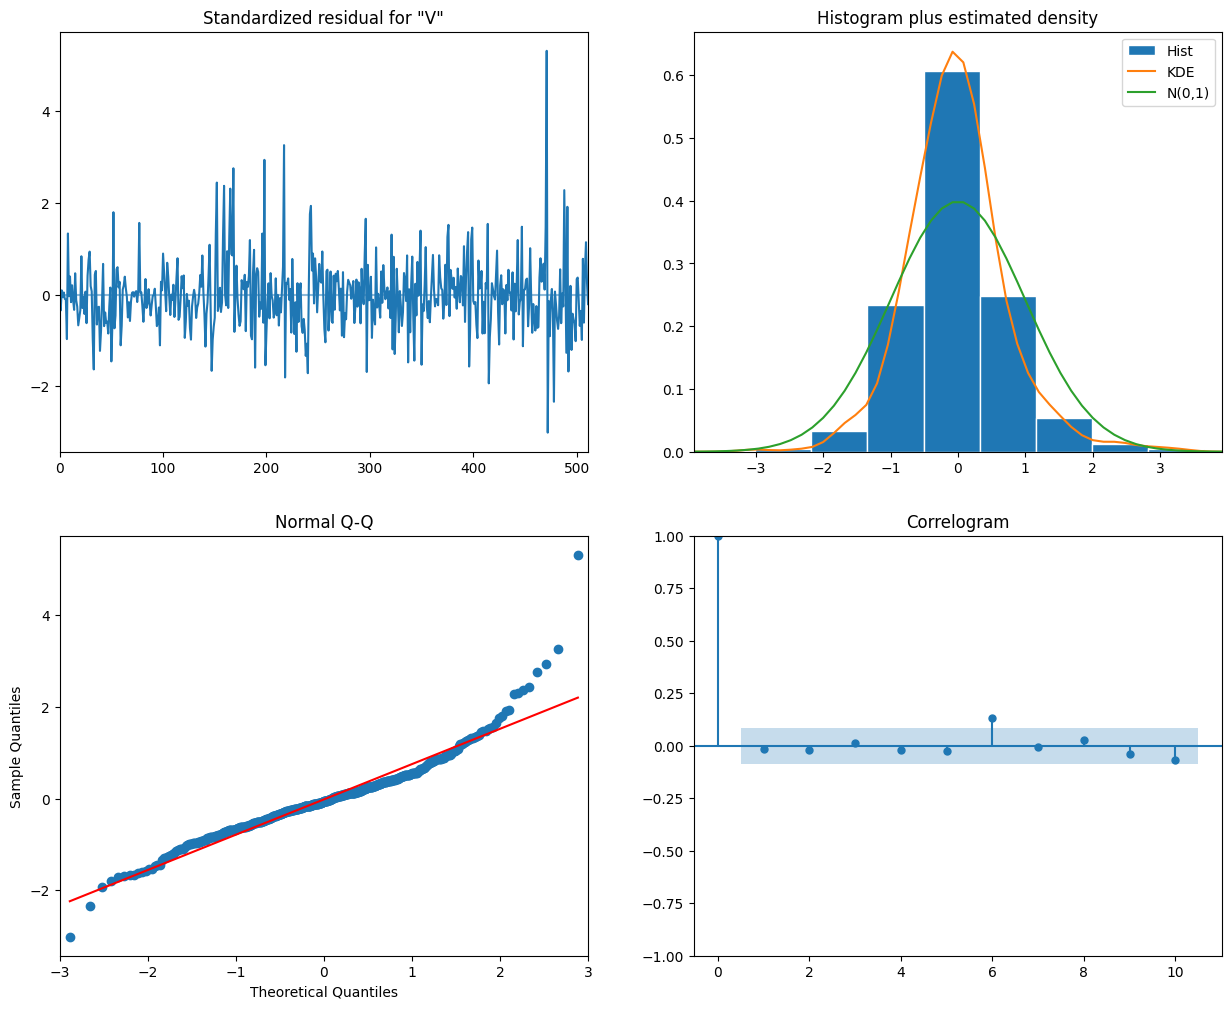

In [100]:
best_model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()  

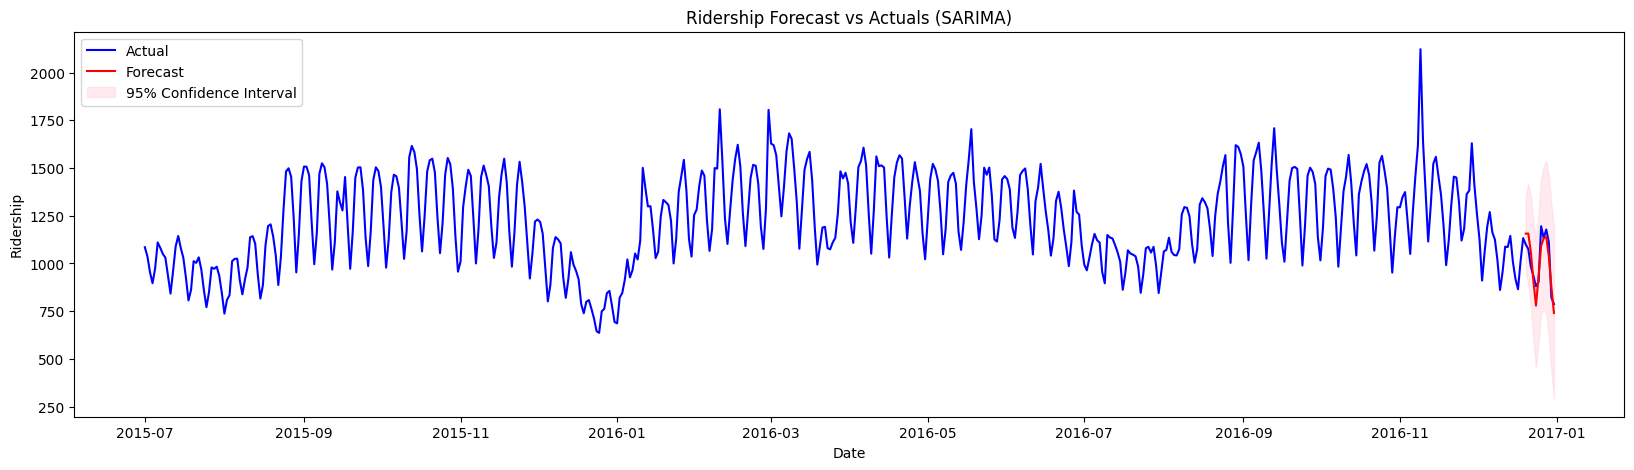

In [102]:
plt.figure(figsize=(20, 5))
plt.plot(df['Date'], df['Views'], label='Actual', color='blue')

# Plot the forecasted values
plt.plot(validation['Date'], forecasted_values, label='Forecast', color='red')

# Plot the confidence interval as a shaded area around the line
plt.fill_between(validation['Date'],
                 conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='pink', alpha=0.3, label='95% Confidence Interval')

plt.title('Ridership Forecast vs Actuals (SARIMA)')
plt.xlabel('Date')
plt.ylabel('Ridership')
plt.legend()
plt.show()